# Breakout Strategy
In this notebook, we will create a trend-following strategy which uses the Bollinger band phases and apply it to the NIKKEI Index.<br><br>
**The notebook is structured as follows**
1. Import and Prepare the Data
2. Create the Bollinger Bands
3. Create Signal
4. Event-Driven Backtesting
5. Plot the PnL Across Time
6. Plot the Positions
7. Compute the Summary Statistics <br>

## Import Libraries

In [1]:
# Import yfinance
import yfinance as yf  

# For data manipulation
import numpy as np
import pandas as pd

# For data visualisation
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

#For strategy analysis
import pyfolio as pf

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/opt/anaconda3/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


# Import Data

We'll be sourcing our data from Yahoo Finance. The selected timeframe from 2016 to 2023 has been chosen to include various market scenarios, a bull market, a bear market, and the market crisis caused by the COVID-19 pandemic.

[*********************100%***********************]  1 of 1 completed


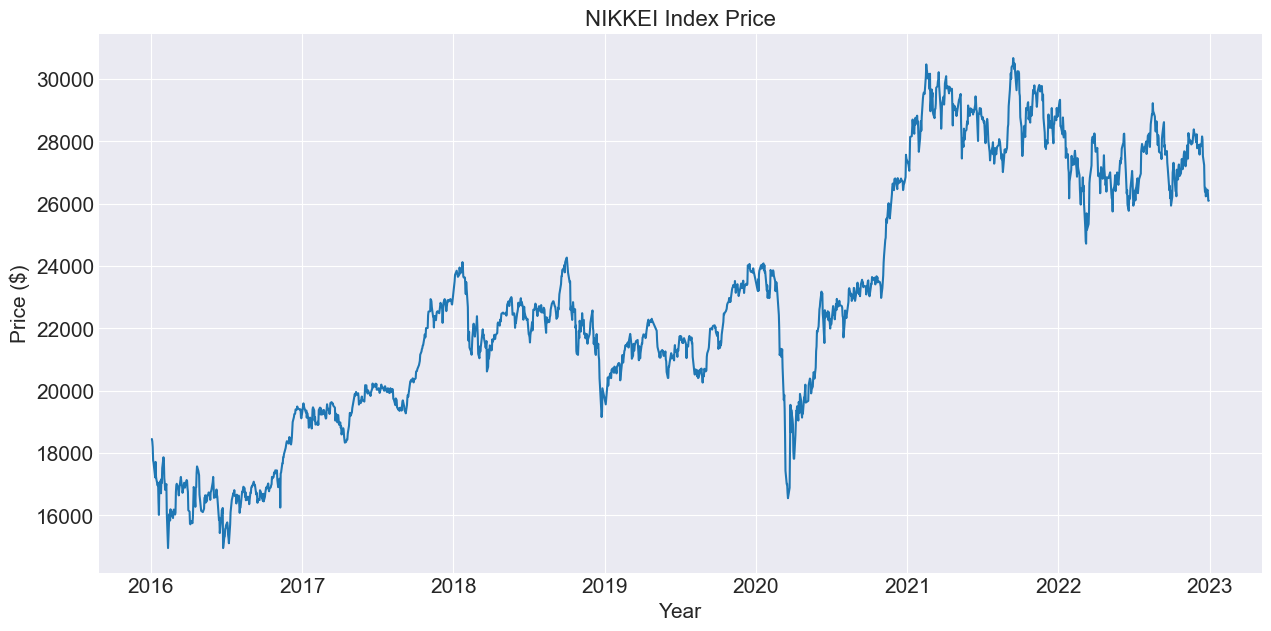

In [2]:
#Define the periode for which we want to fetch data
start_date = '2016-01-01'
end_date = '2023-01-01'
# Get the data for NIKKEI by specifying the stock ticker, start date, and end date
data = yf.download('^N225', start_date, end_date)

# Show the NIKKEI Index Close Price
plt.figure(figsize=(15, 7))
plt.title('NIKKEI Index Price', fontsize=16)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Price ($)', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.plot(data.Close)
plt.show()

# Create the bollinger Bands

In [3]:
#Bollinger Band function
def BBANDS(series, timeperiod, nbdevup=2, nbdevdn=2):
    # Calculate the simple moving average (middle band)
    seriesSMA = series.rolling(window=timeperiod).mean()

    # Calculate the standard deviation
    seriesSTD = series.rolling(window=timeperiod).std()

    # Calculate the upper Bollinger band
    seriesUpper = seriesSMA + (seriesSTD * nbdevup)

    # Calculate the lower Bollinger band
    seriesLower = seriesSMA - (seriesSTD * nbdevdn)
    
    return seriesUpper, seriesSMA, seriesLower

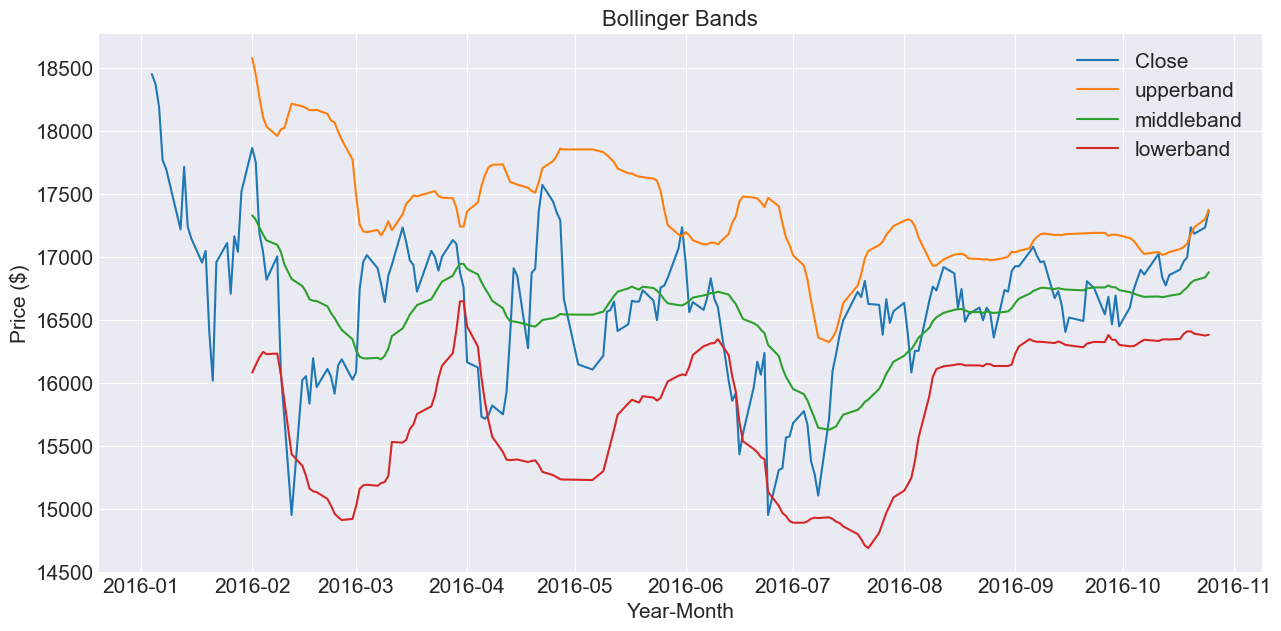

In [4]:
# Compute the bands
data['upperband'], data['middleband'], data['lowerband'] = BBANDS(
    data.Close, timeperiod=20)

# Show the bands for the first 200 observations
plt.figure(figsize=(15, 7))
plt.title('Bollinger Bands', fontsize=16)
plt.xlabel('Year-Month', fontsize=15)
plt.ylabel('Price ($)', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.plot(data[['Close', 'upperband', 'middleband', 'lowerband']][:200])
plt.legend(['Close', 'upperband', 'middleband',
           'lowerband'], prop={'size': 15})
plt.show()

# Create Signal
We're preparing to construct a signal that can help us decide when to buy shares. To do this, we'll use two measures: the `bandwidth` and a `rolling_bandwidth`.

Here are the two things that need to happen for us to consider buying:

1. The stock's price needs to move from a period of little movement (which we call the `Bollinger squeeze` phase) to a period of bigger ups and downs (the `Bollinger expansion` phase). We'll know this has happened when today's `bandwidth` is larger than the rolling_bandwidth.

2. The stock's highest price today should be higher than the top of the Bollinger band.

When both these things happen, we assign 1 to the signal time series meaning it's a good time to buy. If these conditions aren't met, we'll assign 0.

In [5]:
# Calculate the width
data['bandwidth'] = (data['upperband']-data['lowerband'])/data['middleband']

# Calculate the rolling width
data['rolling_bandwidth'] = data['bandwidth'].rolling(21).mean()

# Compute the condition 1
data['cond1'] = data.bandwidth > data.rolling_bandwidth

# Compute the condition 2
data['cond2'] = data.High > data.upperband

# Compute the signal: First step
data['signal'] = np.where(data.cond1 & data.cond2, 1, np.nan)

# Compute the signal: Second step
data['signal'] = np.where(data.Low < data.middleband, 0, data.signal)

# Fill the NaN values with previous observations
data.signal = data.signal.fillna(method='ffill')

# SL and TP
We will exit the long positions by using the `ATR` to set the stop loss and take profit.

In [6]:
#ATR (average true range) function
def ATR(high, low, close, timeperiod=14):
    # Compute true range
    high_low = high - low
    high_close = (high - close.shift()).abs()
    low_close = (low - close.shift()).abs()

    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)

    # Compute average true range
    atr = true_range.rolling(window=timeperiod).mean()
    
    return atr

In [7]:
# Calculate the Average True Range(ATR)
data['ATR'] = ATR(data['High'], data['Low'],
                     data['Close'], timeperiod=14)

In [8]:
# The stop loss target
stop_loss = ''

# The take profit target
take_profit = ''

# The stop loss multiple to calculate its target
stop_loss_multiple = 1

# The take profit multiple to calculate its target
take_profit_multiple = 3

With our `entry` signals, `stop-loss` measures, and `profit targets` in place, it's time to simulate trades using historical data.

But before we jump into that, we should create a structured trading dataframe. This dataframe will include columns for Position, Entry Time, Entry Price, Exit Time, Exit Price, and Profit & Loss (PnL).

In [9]:
# Update the current position whenever we buy or close a position
current_position = 0

# Entry time when we buy the stock
entry_time = np.nan

# Entry price with which whenever we buy the stock
entry_price = np.nan

# Create the dataframe
trades = pd.DataFrame(
    columns=['Position', 'Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'PnL'])
trades

,Position,Entry Time,Entry Price,Exit Time,Exit Price,PnL


We'll develop a function to construct our trade book, a record where we'll store crucial data like `Position`, `Entry Time`, `Entry Price`, `Exit Time`, `Exit Price`, and `PnL`. When updating `PnL`, we must account for the `trading costs` and adjust our profit and loss figures accordingly.

In [10]:
# Calculate the PnL for exit of a long position
def trade_details(data, time, entry_time, entry_price):

    # Profit and Loss computation
    pnl = round(data.loc[time, 'Close'] - entry_price, 2)

    # Calculate trading cost
    trading_cost = data.loc[time, 'Close'] * 0.0002 * 2

    # Profit and Loss net of trading cost
    pnl = pnl - trading_cost

    # Create dataframe to paste the details
    trades = pd.DataFrame(
        columns=['Position', 'Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'PnL'])

    # Append the details
    details = {'Position': 'Long', 'Entry Time': entry_time, 'Entry Price': entry_price,
               'Exit Time': time, 'Exit Price': data.loc[time, 'Close'], 'PnL': pnl}

    return trades.append(details, ignore_index=True)

In [11]:
# Create the trade details in case we buy on Jan 2nd 2019
trade_details(data, '2019-01-30', '2019-01-02', 15.33)

,Position,Entry Time,Entry Price,Exit Time,Exit Price,PnL
0,Long,2019-01-02,15.33,2019-01-30,20556.539062,20532.987384


In [12]:
for time in data.index:
    # ---------------------------------------------------------------------------------
    # Long Position
    if (current_position == 0) and (data.loc[time, 'signal'] == 1):

        # We update the current position to 1
        current_position = 1

        # We save the date in which we go long
        entry_time = time

        # We save the price with which we buy the stock
        entry_price = data.loc[time, 'Close']

        # We specify the stop loss target
        stop_loss = entry_price - data.loc[time, 'ATR'] * stop_loss_multiple

        # We specify the take profit target
        take_profit = entry_price + \
            data.loc[time, 'ATR'] * take_profit_multiple

    # ---------------------------------------------------------------------------------
    # Long Exit
    elif (current_position == 1):
        # Check for sl and tp in case any of them are breached
        if data.loc[time, 'Close'] < stop_loss or data.loc[time, 'Close'] > take_profit:

            # Get the trade details
            trade_details_ = trade_details(data, time, entry_time, entry_price)

            # Save the trade details in our trades dataframe
            trades = pd.concat([trades, trade_details_])
            trades = trades.reset_index(drop=True)

            # We update the current position to zero
            current_position = 0

In [13]:
trades

,Position,Entry Time,Entry Price,Exit Time,Exit Price,PnL
0,Long,2016-10-21,17184.589844,2016-11-04,16905.359375,-285.992144
1,Long,2017-05-08,19895.699219,2017-05-18,19553.859375,-349.661544
2,Long,2017-05-19,19590.759766,2017-06-02,20177.279297,578.449088
3,Long,2017-09-19,20299.380859,2017-10-11,20881.269531,573.537492
4,Long,2017-10-12,20954.720703,2017-10-17,21336.119141,372.865552
5,Long,2017-10-18,21363.050781,2017-10-24,21805.169922,433.397932
6,Long,2017-10-25,21707.619141,2017-11-01,22420.080078,703.491968
7,Long,2017-11-02,22539.119141,2017-11-15,22028.320312,-519.611328
8,Long,2018-01-04,23506.330078,2018-01-23,24124.150391,608.170340
9,Long,2018-01-24,23940.779297,2018-01-25,23669.490234,-280.757796


# Visualise PnL Over Time

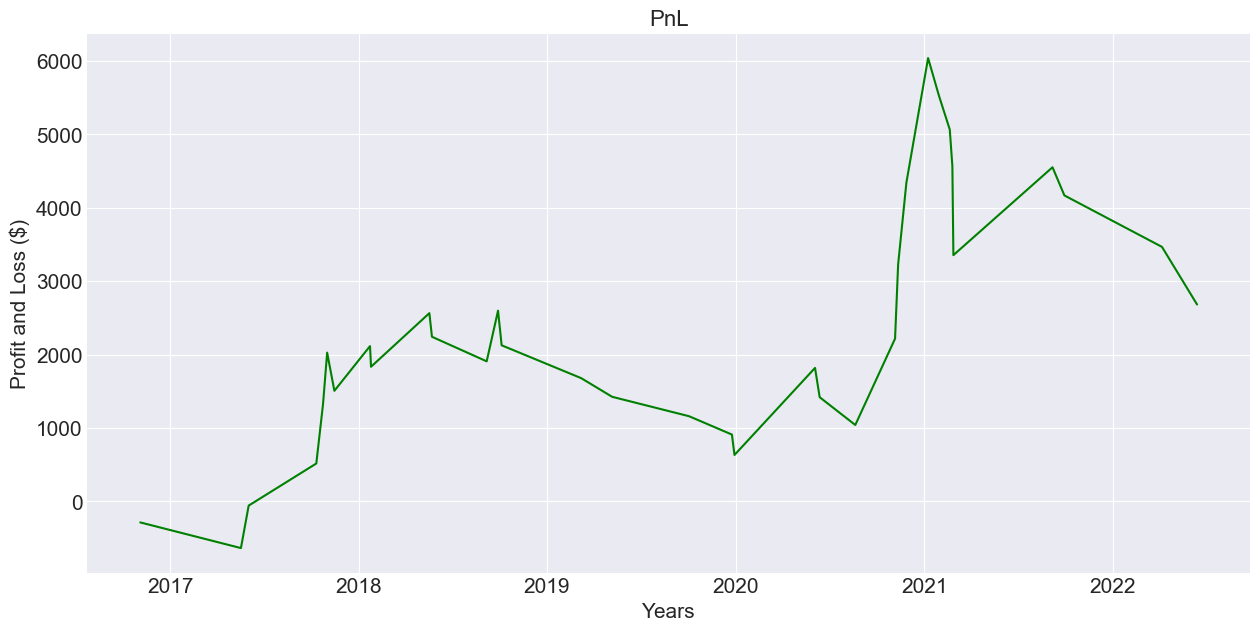

In [14]:
# Define the figure size for the plot
plt.figure(figsize=(15, 7))

# Define the label for the title of the figure
plt.title("PnL", fontsize=16)

# Define the labels for x-axis and y-axis
plt.xlabel("Years", fontsize=15)
plt.ylabel("Profit and Loss ($)", fontsize=15)

# Define the tick size for x-axis and y-axis
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Plotting the PnL across time
plt.plot(trades['Exit Time'], trades.PnL.cumsum(), color='g')
plt.show()

# Visualise Entry and Exit points

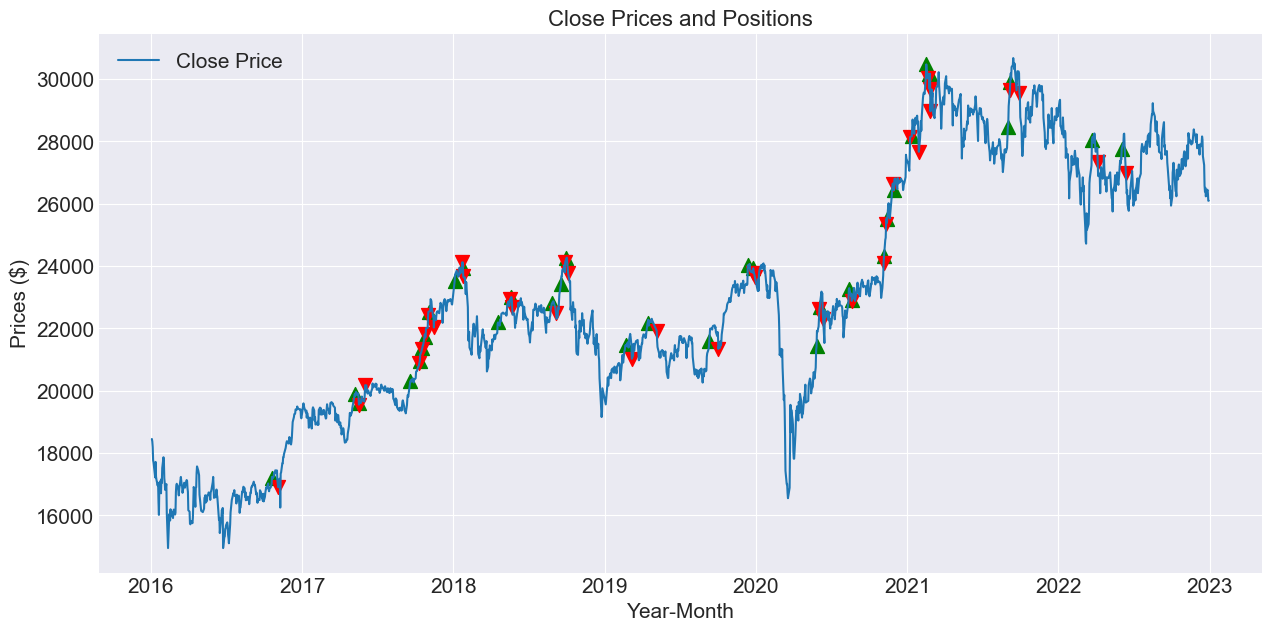

In [15]:
# Create the long_position column
data['buy_signal'] = np.nan
data['sell_signal'] = np.nan

# Assign the entry price to the buy signal
data.loc[data.index.isin(trades['Entry Time']), 'buy_signal'] = trades['Entry Price'].values

# Assign the exit price to the sell signal
data.loc[trades['Exit Time'], 'sell_signal'] = trades['Exit Price'].values

# Plot the Positions and Close Prices
plt.figure(figsize=(15, 7))
plt.plot('Close', data=data, label='Close Price')
plt.scatter(data.index, data['buy_signal'],
            color='green', marker='^', alpha=1, s=100)
plt.scatter(data.index, data['sell_signal'],
            color='red', marker='v', alpha=1, s=100)
dates = data.index.strftime('%Y-%m')

# Set the title and axis labels
plt.title('Close Prices and Positions', fontsize=16)
plt.xlabel('Year-Month', fontsize=15)
plt.ylabel('Prices ($)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', prop={'size': 15})
plt.show()

# Create Strategy Analysis

Start date,2016-01-04
End date,2022-12-30
Total months,81
,Backtest
Annual return,2.096%
Cumulative returns,15.118%
Annual volatility,6.442%
Sharpe ratio,0.40
Calmar ratio,0.16
Stability,0.61
Max drawdown,-12.791%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,12.79,2021-01-25,2022-06-13,NaT,NaN
1,8.18,2018-10-02,2019-12-30,2020-11-09,550
2,4.77,2016-10-28,2017-05-18,2017-10-10,248
3,3.96,2017-11-07,2017-11-15,2018-05-14,135
4,2.77,2018-05-21,2018-09-06,2018-09-28,95


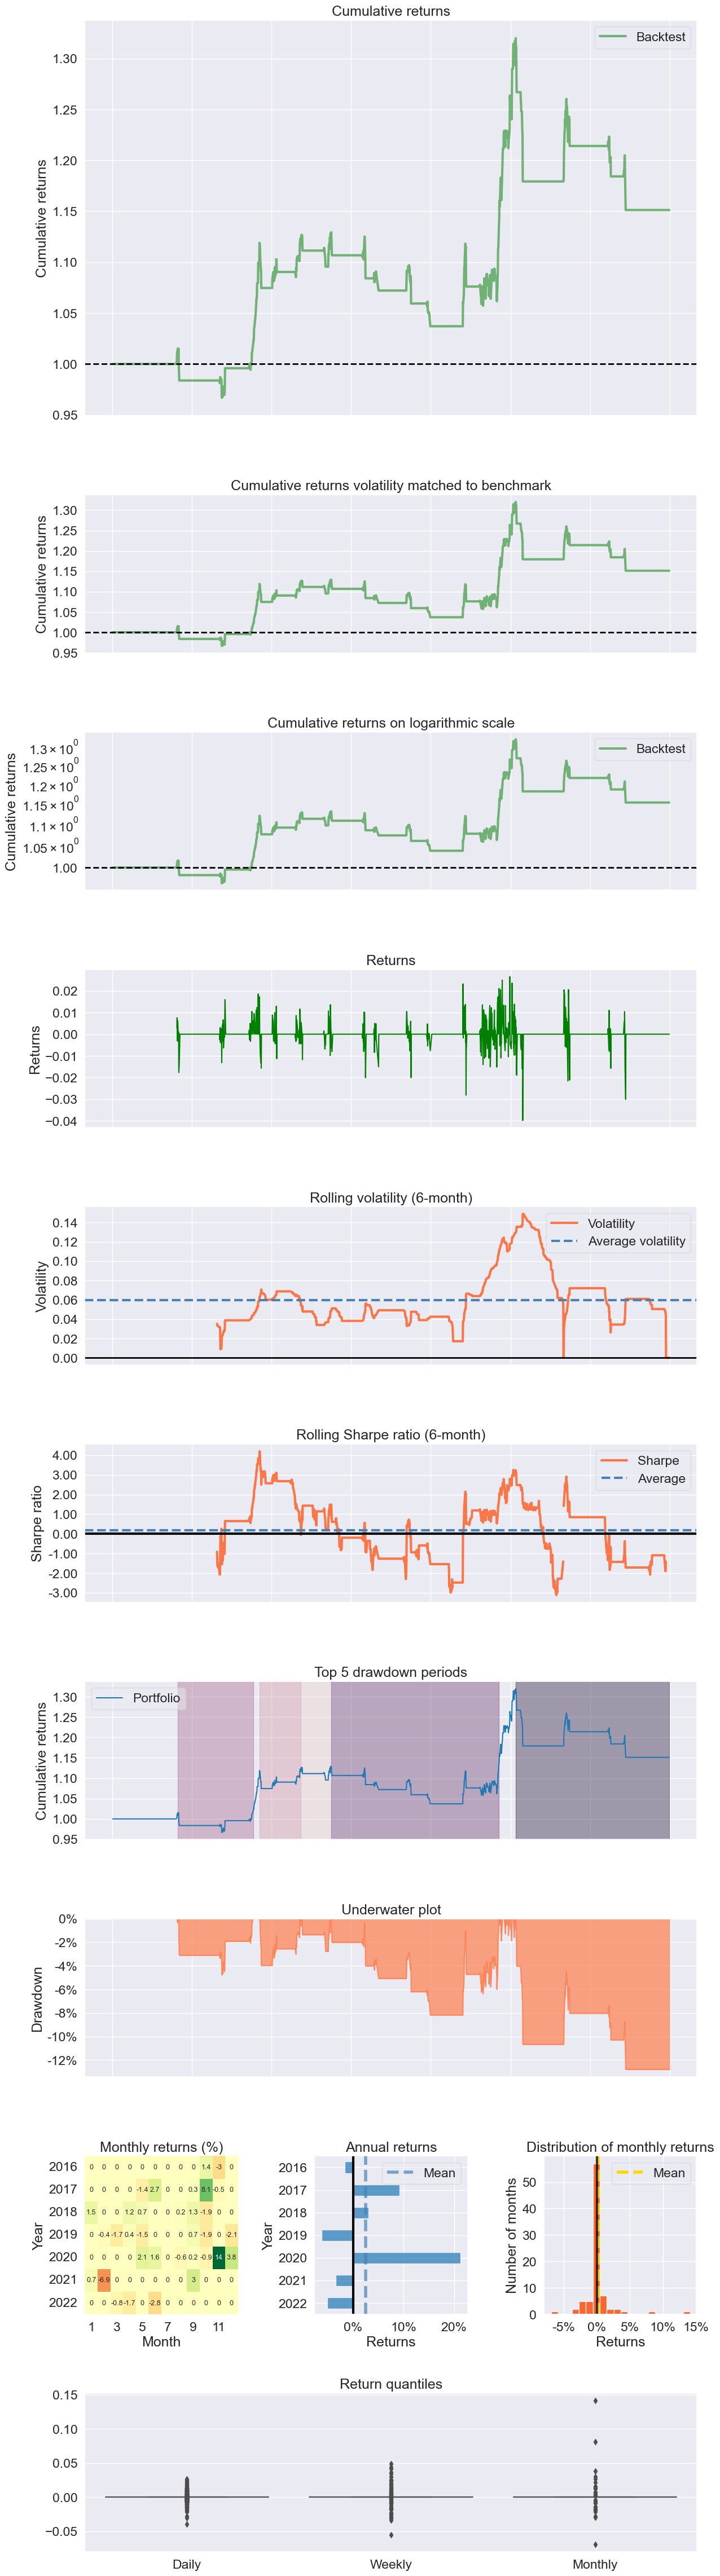

In [16]:
# Create the long_position column
data['long_position'] = np.nan

# Assign a value of 1 to long position
data.loc[data.index.isin(trades['Entry Time']), 'long_position'] = 1

# Assign a value of 0 to `long_position`
data.loc[data.index.isin(trades['Exit Time']), 'long_position'] = 0

# Replace Nan Values with previous values
data.long_position.fillna(method='ffill', inplace=True)

# Compute the strategy returns
data['strategy_returns'] = data.long_position.shift(
    1) * data.Close.pct_change()

# Compute the strategy statistics and graph them
pf.create_returns_tear_sheet(data['strategy_returns'])